In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Jumlah tempat wisata:  523
Jumlah rating:  10300
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Place_Id     523 non-null    int64  
 1   Place_Name   523 non-null    object 
 2   Description  523 non-null    object 
 3   Category     523 non-null    object 
 4   City         523 non-null    object 
 5   Price        523 non-null    int64  
 6   Rating       431 non-null    float64
 7   No.Telepon   523 non-null    object 
 8   Coordinate   523 non-null    object 
 9   Latitude     521 non-null    float64
 10  Longitude    523 non-null    float64
dtypes: float64(3), int64(2), object(6)
memory usage: 45.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10300 entries, 0 to 10299
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10300 non-null  int6

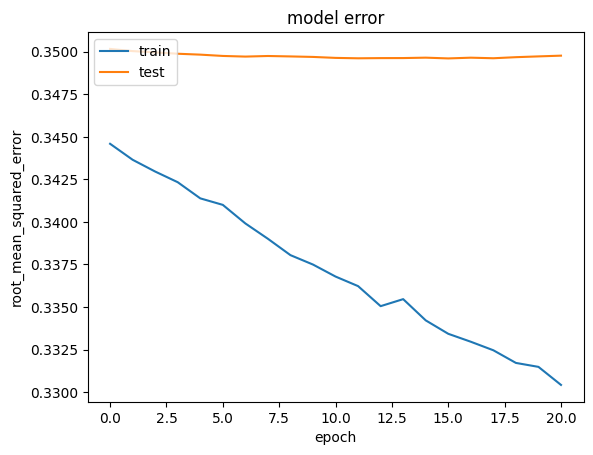

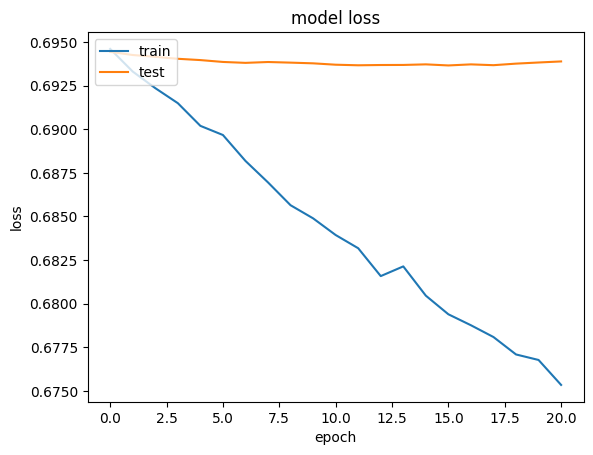

16/16 [==============================] - 0s 2ms/step
Showing recommendations for users: 152
Place with high ratings from user
----------------------------------------
The Great Asia Africa: Taman Hiburan, Bandung
Tebing Karaton: Cagar Alam, Bandung
Danau Elysium: Cagar Alam, Bekasi
Danau Summarecon Bekasi: Cagar Alam, Bekasi
Inkarla Agro Wisata: Budaya, Cianjur
Telaga Biru: Cagar Alam, Cianjur
Coral Coast Paranje: Cagar Alam, Garut
Kebun Mawar Situhapa: Taman Hiburan, Garut
Bukit Lolongokan: Cagar Alam, Garut
Taman Rusa Bumi Patra Indramayu: Taman Hiburan, Indramayu
Wisata Alam Kaliwungu: Taman Hiburan, Karawang
Taman Hud-hud: Taman Hiburan, Karawang
Natural Park (TWA) Linggarjati: Cagar Alam, Kuningan
Panorama Nature Cikebo: Cagar Alam, Majalengka
Hutan Pinus Batu Nyongclo: Cagar Alam, Majalengka
Taman Gunung Batu Karang: Taman Hiburan, Majalengka
Bukit Mercury Sayang Kaak: Cagar Alam, Majalengka
Batu Karas Surf Spot: Cagar Alam, Pangandaran
Pangandaran Beach: Cagar Alam, Pangandaran


In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Membaca Data dari Dataset
places = pd.read_csv('/content/drive/MyDrive/data/Data_Destination_Tourism_West_java.csv', encoding = 'ISO-8859-1')
ratings = pd.read_csv('/content/drive/MyDrive/data/tourism_rating.csv')

# Jumlah data
print('Jumlah tempat wisata: ', len(places.Place_Id.unique()))
print('Jumlah rating: ', len(ratings.Place_Ratings))

# Konversi kolom 'Latitude' ke float64
places['Latitude'] = pd.to_numeric(places['Latitude'], errors='coerce')

# Konversi kolom 'Rating ke float64
places['Rating'] = pd.to_numeric(places['Rating'], errors = 'coerce')

# Periksa kembali informasi dataset
print(places.info())
print(ratings.info())

places.head()
places.describe()
ratings.head()
ratings.describe()

places = places.drop(['Description', 'Price', 'Rating', 'No.Telepon', 'Coordinate', 'Latitude', 'Longitude'], axis = 1)
places.isnull().sum()
ratings.isnull().sum()

# Pengecekan data duplikan

print(f'Jumlah data destinasi wisata yang duplikat: {places.duplicated().sum()}')
print(f'Jumlah data rating pengguna wisata yang duplikat: {ratings.duplicated().sum()}')

# Menghapus data duplikat (Ratings)
ratings.drop_duplicates(inplace = True)

# Proces encoding fitur User_Id pada dataset ratings menjadi array
user_ids = ratings['User_Id'].unique().tolist()
print('list User_Id: ', user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded User_Id : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke User_Id: ', user_encoded_to_user)

# Proses encoding fitur Place_Id pada dataset rating menjadi array
place_ids = ratings['Place_Id'].unique().tolist()
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

# Mapping pemetaan kolom user dan place ke dataset rating yang berkaitan
ratings['user'] = ratings['User_Id'].map(user_to_user_encoded)
ratings['place'] = ratings['Place_Id'].map(place_to_place_encoded)


# Pengecekan jumlah user, jumlah destinasi, rating minimal, dan rating maksimal

users_count = len(user_to_user_encoded)
place_count = len(place_encoded_to_place)

ratings['rating'] = ratings['Place_Ratings'].values.astype(np.float32)

min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

print(f'Users Count: {users_count}')
print(f'Places Count: {place_count}')
print(f'Min rating: {min_rating}')
print(f'Max rating: {max_rating}')

# Mengacak dataset rating
ratings = ratings.sample(frac=1, random_state=42)
ratings

x = ratings[['user', 'place']].values
y = ratings['rating'].apply(lambda x: (
    x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

class RecommenderNet(tf.keras.Model):
    def __init__(self, users_count, place_count, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.users_count = users_count
        self.place_count = place_count
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            users_count,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-8)
        )
        self.user_bias = layers.Embedding(users_count, 1)
        self.place_embedding = layers.Embedding(
            place_count,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-8)
        )
        self.place_bias = layers.Embedding(place_count, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        place_bias = self.place_bias(inputs[:, 1])

        dot_user_place = tf.tensordot(user_vector, place_vector, 2)

        x = dot_user_place + user_bias + place_bias

        return tf.nn.sigmoid(x)

# Fix indentation here
model = RecommenderNet(users_count, place_count, 50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Menambahkan Callback EarlyStopping jika tidak ada peningkatan selama 5 epochs
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_root_mean_squared_error',
    min_delta = 1e-4,
    patience = 10,
    restore_best_weights = True
)

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 500,
    validation_data = (x_val, y_val),
    callbacks = [callbacks]
)

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

place_df = places
ratings_df = ratings

user_id = ratings_df.User_Id.sample(1).iloc[0]
place_rated = ratings_df[ratings_df.User_Id == user_id]

place_not_rated = place_df[~place_df['Place_Id'].isin(
    place_rated.Place_Id.values)]['Place_Id']
place_not_rated = list(
    set(place_not_rated).intersection(set(place_to_place_encoded.keys()))
)

place_not_rated = [
    [place_to_place_encoded.get(x)] for x in place_not_rated]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_rated), place_not_rated)
)

ratings = model.predict(user_place_array).flatten()

top_ratings_indices = ratings.argsort()[-20:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_rated[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('=====' * 8)
print('Place with high ratings from user')
print('-----' * 8)

top_place_user = (
    place_rated.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(20)
    .Place_Id.values
)

place_df_rows = place_df[place_df['Place_Id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.Place_Name + ':', row.Category + ',', row.City)

print('-----' * 8)
print('Top 20 place recommendation')
print('-----' * 8)

recommended_place = place_df[place_df['Place_Id'].isin(recommended_place_ids)]
for row in recommended_place.itertuples():
    print(row.Place_Name + ':', row.Category + ',', row.City)


In [6]:
# Save weights
model.save_weights('/content/drive/MyDrive/data/recommendation_model_weights.h5')

# Menyimpan model ke dalam file .pickle
import pickle
with open('/content/drive/MyDrive/data/recommendation_model.pickle', 'wb') as f:
    pickle.dump(model, f)